In [29]:
import os
from glob import glob
import shutil
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tff
from skimage.io import imsave
from skimage import measure
from matplotlib.path import Path
from registration import CrossCorr


In [30]:
# imgPath = '/Users/zhengj10/Desktop/iGABASnFR/Dish_2/'

# dataPath = 'Y:\\iGABASnFR'
dataPath = 'Y:\\iGABASnFR_spontaneous_activity\\'
date = '210513'
dish = 'Dish_1'

ctrPath = os.path.join(dataPath,date,dish,'Control')
tgbPath = os.path.join(dataPath,date,dish,'Tiagabine')

ctr_sum_path = os.path.join(ctrPath, 'summary')
tgb_sum_path = os.path.join(tgbPath, 'summary')


True

### For new data run this block to check each FOV and ROI

In [31]:
ctr_img_files = glob(ctrPath+'/*.mat')
tgb_img_files = glob(tgbPath+'/*.mat')
ctr_img_files = sorted(ctr_img_files)
tgb_img_files = sorted(tgb_img_files)

algorithm = CrossCorr()

for fov in range(len(ctr_img_files)):
    print(ctr_img_files[fov])
    ctr_img_data = loadmat(ctr_img_files[fov])
    ctr_img_data = ctr_img_data['data']
    ctr_img_data_aslist=[]
    for frame in range(500,3000):
        ctr_img_data_aslist.append(ctr_img_files[:,0][frame])
    ctr_img_data = np.array(ctr_img_data_aslist)    
    
    tgb_img_data = loadmat(tgb_img_files[fov])
    tgb_img_data = tgb_img_data['data']
    tgb_img_data_aslist=[]
    for frame in range(500,3000):
        tgb_img_data_aslist.append(tgb_img_files[:,0][frame])
    tgb_img_data = np.array(tgb_img_data_aslist)
    
    reference = ctr_img_data[100]
    model = algorithm.fit(tgb_img_data,reference)
    registered = model.transform(tgb_img_data)
    registered = registered.toarray()
    
    img_norm = (ctr_img_data/imgData[0])-1

    act_pix = []
    for i in range(10,2490):
        a = (np.mean(img_norm[i+1:i+10,:,:],axis=0)-np.mean(img_norm[i-10:i,:,:],axis=0))>0.04
        act_pix.append(a)
    act_pix = np.array(act_pix)
    act_pix = np.max(act_pix,axis=0)

    contours = measure.find_contours(act_pix, 0.1)
    thre = 20 # Exclude small ROIs
    rois = []
    
    coordinates = []
    for r in range(act_pix.shape[0]):
        for c in range(act_pix.shape[1]):
            coordinates.append([r,c])
    coordinates = np.array(coordinates)
    
    for contour in contours:
        if contour.shape[0]>thre:
            p = Path(contour)
            roi = p.contains_points(coordinates)
            roi = roi.reshape(512,512)
            rois.append(roi)

    if len(rois) == 0:
        print('FOV_'+str(fov+1).zfill(3)+': no active pixels')
        continue
        
    fig = plt.figure(figsize=[10,10])
    for contour in contours:
        if contour.shape[0]>thre:
            plt.plot(contour[:,1], contour[:, 0], color = 'lime',lw=1)
            
    plt.axis('off')
    plt.tight_layout()
    fig.savefig('C:\\Users\\zhengj10\\Desktop\\Jihong\\FOV_'+str(fov+1).zfill(3)+'_ROI.pdf',format='pdf')
    print('FOV_'+str(fov+1).zfill(3)+' ROI image saved')
    fig.clear()
    plt.close(fig)

    Fb = np.min(imgData[-1,:,:])
    F0 = np.mean(imgData[:10,:,:],axis=0)
    
    fig = plt.figure(figsize=[12,len(rois)/2.0+0.1])

    offset_step = 0
    for roi in range(len(rois)):
        offset = 0.4*offset_step
        dFF_all = []
        for frame in range(ctr_img_data.shape[0]):
            F_single = np.sum(rois[roi]*ctr_img_data[frame,:,:])/np.sum(rois[roi])
            dFF = (F_single - np.sum(rois[roi]*F0)/np.sum(rois[roi]))/(np.sum(rois[roi]*F0)/np.sum(rois[roi])-Fb)
            dFF_all.append(dFF)
        dFF_all = np.array(dFF_all)
        plt.plot(dFF_all - offset*0.5, zorder=roi+1, color='k', lw=1,alpha=0.8)
        plt.axis('off')

        
        
        for frame in range(registered.shape[0]):
            F_single = np.sum(rois[roi]*registered[frame,:,:])/np.sum(rois[roi])
            dFF = (F_single - np.sum(rois[roi]*F0)/np.sum(rois[roi]))/(np.sum(rois[roi]*F0)/np.sum(rois[roi])-Fb)
            dFF_all.append(dFF)
        dFF_all = np.array(dFF_all)
        plt.plot(dFF_all - offset, zorder=roi+1, color='k', lw=1,alpha=0.8)
        plt.axis('off')
        offset_step += 1
        
        
        
        
#     plt.plot([2350,2450,2450],[-0.2*offset_step-0.1,-0.2*offset_step-0.1,-0.2*offset_step+0.1],color='k',alpha=0.8)
    plt.tight_layout()
#     fig.savefig('C:\\Users\\zhengj10\\Desktop\\Jihong\\dFF_FOV_'+str(fov+1).zfill(3)+'.pdf',format='pdf')
plt.show()


Y:\iGABASnFR_spontaneous_activity\210513\Dish_1\Control\FOV_00001.mat
(2400, 512, 512)
FOV_001 ROI image saved


### Run the following to exclude bad FOV and ROI

In [27]:
### 210128\\Dish_1
# bad_FOVs = {
    
#     1:'No active pixels',
#     9:'Barrage synchronized response',
#     16:'Barrage synchronized response'
    
# }


# bad_rois = {
#     1:[],
#     2:[0,1,5],
#     3:[1],
#     4:[0],
#     5:[0,1,2],
#     6:[],
#     7:[5.6],
#     8:[],
#     9:[],
#     10:[],
#     11:[],
#     12:[0],
#     13:[1,7],
#     14:[],
#     15:[],
#     16:[],
#     17:[0,1],
#     18:[0],
#     19:[],
#     20:[]
    
# }

bad_FOVs = {
    
   
    
}


bad_rois = {
   
    
}


In [17]:
data_all = {}
for param in['Date','Dish','Sensor','Light_source','Imaging_power','Frame_rate (Hz)','Exposure_time (ms)','Bad_FOV',
            'Remark','No._of_ROIs','Objective']:
    data_all[param] = []

In [18]:
imgFiles = glob(imgPath+'/*.mat')
imgFiles = sorted(imgFiles)
len(imgFiles)

dFF_all_FOVs_ROIs = {}

for fov in range(len(imgFiles)):
    print(imgFiles[fov])
    
    data_all['Date'].append(date)
    data_all['Dish'].append(dish)
    data_all['Sensor'].append(sensors[dish])
    data_all['Light_source'].append('cyan')
    data_all['Imaging_power'].append('10%')
    data_all['Frame_rate (Hz)'].append(100)
    data_all['Exposure_time (ms)'].append(5)
    data_all['Objective'].append('40x oil GENIE')
    
    if fov+1 in bad_FOVs:
        data_all['Bad_FOV'].append('Yes')
        data_all['Remark'].append(bad_FOVs[fov+1])
        data_all['No._of_ROIs'].append('N/A')
        continue
    else:
        data_all['Bad_FOV'].append('No')
        data_all['Remark'].append('N/A')
        

    imgData = loadmat(imgFiles[fov])
    imgData = imgData['data']
    imgData_aslist=[]
    for frame in range(500,2900):
        imgData_aslist.append(imgData[:,0][frame])
    imgData = np.array(imgData_aslist)
    print(imgData.shape)
    img_norm = (imgData/imgData[0])-1

    act_pix = []
    for i in range(10,2390):
        a = (np.mean(img_norm[i+1:i+10,:,:],axis=0)-np.mean(img_norm[i-10:i,:,:],axis=0))>0.04
        act_pix.append(a)
    act_pix = np.array(act_pix)
    act_pix = np.max(act_pix,axis=0)
    
    contours = measure.find_contours(act_pix, 0.1)
    thre = 20 # Exclude small ROIs
    rois = []
    
    coordinates = []
    for r in range(act_pix.shape[0]):
        for c in range(act_pix.shape[1]):
            coordinates.append([r,c])
    coordinates = np.array(coordinates)
    
    for contour in contours:
        if contour.shape[0]>thre:

            p = Path(contour)
            roi = p.contains_points(coordinates)
            roi = roi.reshape(512,512)
            rois.append(roi)

    fig = plt.figure(figsize=[5,5])    
    plt.imshow(act_pix)
    for contour in contours:
        if contour.shape[0]>thre:
            plt.plot(contour[:,1], contour[:, 0], color = 'lime',lw=1)
            
    plt.axis('off')
    plt.tight_layout()
    fig.savefig(sumPath+'\\FOV_'+str(fov+1).zfill(3)+'_ROI.pdf',format='pdf')
    print('FOV_'+str(fov+1).zfill(3)+' ROI image saved')
    fig.clear()
    plt.close(fig)

    Fb = np.min(imgData[-1,:,:])
    F0 = np.mean(imgData[:10,:,:],axis=0)
    
    fig = plt.figure(figsize=[12,len(rois)/2.0 + +0.1])
    
    dFF_all_FOVs_ROIs[fov+1] = []
    offset_step = 0
    
    for roi in range(len(rois)):
#         if roi in bad_rois[fov+1]:
#             continue
        offset = 0.2*offset_step
        dFF_all = []
        for frame in range(imgData.shape[0]):
            F_single = np.sum(rois[roi]*imgData[frame,:,:])/np.sum(rois[roi])
            dFF = (F_single - np.sum(rois[roi]*F0)/np.sum(rois[roi]))/(np.sum(rois[roi]*F0)/np.sum(rois[roi])-Fb)
            dFF_all.append(dFF)
        dFF_all = np.array(dFF_all)
        plt.plot(dFF_all - offset, zorder=roi+1, color='k', lw=1,alpha=0.8)
        plt.axis('off')
        offset_step += 1
        dFF_all_FOVs_ROIs[fov+1].append(dFF_all)
        
    data_all['No._of_ROIs'].append(offset_step+1)
    
    plt.plot([2350,2450,2450],[-0.2*offset_step-0.1,-0.2*offset_step-0.1,-0.2*offset_step+0.1],color='k',alpha=0.8)
    plt.tight_layout()
#     fig.savefig(sumPath+'\\dFF_FOV_'+str(fov+1).zfill(3)+'.pdf',format='pdf')
    fig.clear()
    plt.close(fig)


Y:\iGABASnFR_spontaneous_activity\210513\Dish_1\Tiagabine\FOV_00001.mat
(2400, 512, 512)
FOV_001 ROI image saved
Y:\iGABASnFR_spontaneous_activity\210513\Dish_1\Tiagabine\FOV_00002.mat


C:\Users\zhengj10\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:102: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


(2400, 512, 512)
FOV_002 ROI image saved
Y:\iGABASnFR_spontaneous_activity\210513\Dish_1\Tiagabine\FOV_00003.mat
(2400, 512, 512)
FOV_003 ROI image saved
Y:\iGABASnFR_spontaneous_activity\210513\Dish_1\Tiagabine\FOV_00004.mat
(2400, 512, 512)
FOV_004 ROI image saved
Y:\iGABASnFR_spontaneous_activity\210513\Dish_1\Tiagabine\FOV_00005.mat
(2400, 512, 512)
FOV_005 ROI image saved
Y:\iGABASnFR_spontaneous_activity\210513\Dish_1\Tiagabine\FOV_00006.mat
(2400, 512, 512)
FOV_006 ROI image saved
Y:\iGABASnFR_spontaneous_activity\210513\Dish_1\Tiagabine\FOV_00007.mat
(2400, 512, 512)
FOV_007 ROI image saved
Y:\iGABASnFR_spontaneous_activity\210513\Dish_1\Tiagabine\FOV_00008.mat
(2400, 512, 512)
FOV_008 ROI image saved
Y:\iGABASnFR_spontaneous_activity\210513\Dish_1\Tiagabine\FOV_00009.mat
(2400, 512, 512)
FOV_009 ROI image saved
Y:\iGABASnFR_spontaneous_activity\210513\Dish_1\Tiagabine\FOV_00010.mat
(2400, 512, 512)
FOV_010 ROI image saved
Y:\iGABASnFR_spontaneous_activity\210513\Dish_1\Tiagabi

In [9]:
# df = pd.read_excel(sumPath+'\\log.xlsx')
# df


In [ ]:
df_new = pd.DataFrame(data_all)

In [ ]:
# df = df.append(df_new)

In [ ]:
# df.to_excel(sumPath+'\\log.xlsx')

In [19]:
import pickle
with open(sumPath+'\\dFF_all_FOVs_ROIs.pickle', 'wb') as handle:
    pickle.dump(dFF_all_FOVs_ROIs, handle, protocol=pickle.HIGHEST_PROTOCOL)


- check individual ROV

15 16


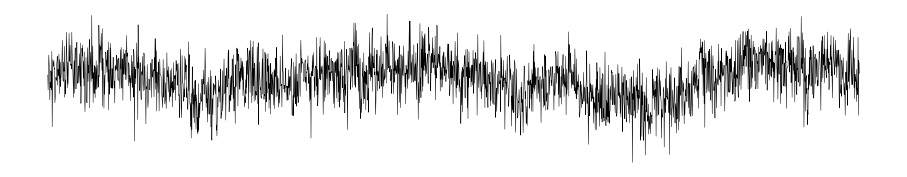

In [20]:
fig = plt.figure(figsize=[16,3])
for dff in dFF_all_FOVs_ROIs[10]:

    if np.std(dff[:100]) > 0.02:
        print(k,id)
        continue

    id+=1
    offset = 0.1*i
    dff = np.array(dff)
    dff = signal.detrend(dff)

    plt.fill_between(x,dff - offset, 0 - offset, 
         zorder=i+1, 
         facecolor='w', edgecolor='w', 
         lw=0, 
         closed=True)
    plt.plot(x,dff - offset, zorder=i+1, color='k', lw=0.5)
    plt.axis('off')
    i+=1

- Dict structure check

In [21]:
for k,v in dFF_all_FOVs_ROIs.items():
    print(k)

dFF_all_FOVs_ROIs[10][0].shape



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


(2400,)

### Plot all ROIs from a dish

2 2
2 3
2 5
4 0
7 0
8 1
8 2
9 1
9 5
9 6
9 7
10 0
11 0
12 0
12 2
12 4
12 5
12 6
12 7
13 2
13 6
13 7
14 5
15 0
15 4


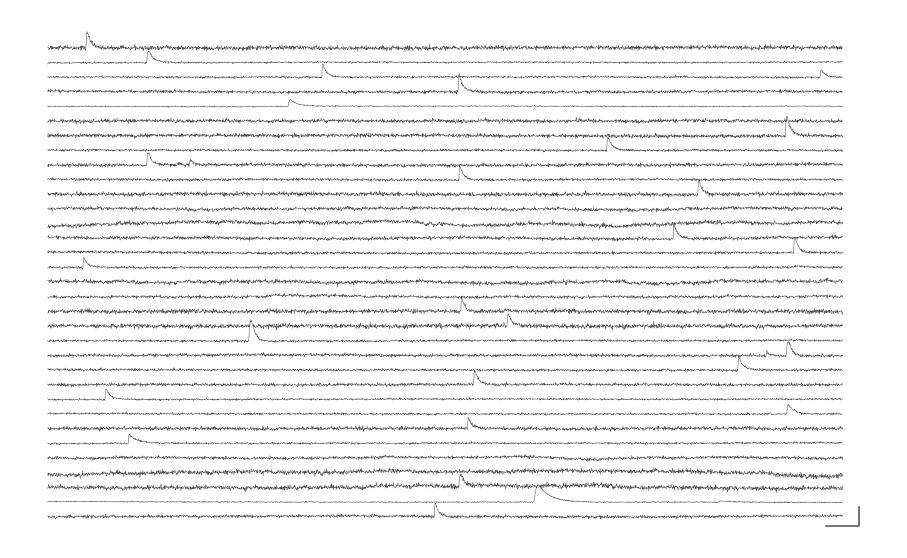

In [28]:
from scipy import signal
fig = plt.figure(figsize=[16,10])
i = 0
x = np.arange(2400)



for k,v in dFF_all_FOVs_ROIs.items():
    for id in range(len(v)):
        
#         # The following block of code exclude bad ROIs further identified from new data processing

        if np.std(v[id][:100]) > 0.012:
            print(k,id)
            continue
#         if k==7 and id in [5,6]:
#             continue
#         if k==10:
#             continue
#         if k==14 and id in [1]:
#             continue
        
        offset = 0.15*i
        dff = np.array(v[id])
        dff = signal.detrend(dff)
        
        plt.fill_between(x, dff-offset, 0-offset, zorder=i+1, facecolor='w', edgecolor='w', lw=0, closed=True)
        plt.plot(x, dff-offset, zorder=i+1, color='k', lw=0.5, alpha=0.7)
        plt.axis('off')
        i+=1
plt.plot([2350,2450,2450],[-offset-0.1,-offset-0.1,-offset+0.1],color='k',alpha=0.7)
# plt.tight_layout()
# fig.savefig(sumPath+'\\dFF_all_ROIs.png',dpi=1200)
# fig.savefig(sumPath+'\\dFF_all_ROIs.pdf',format='pdf')


In [ ]:
i # total ROIs in plot above